In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import cv2
import os
import sklearn
from queue import Queue
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, Dropout, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.data import Dataset
from IPython.display import display
import PIL
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import*
#from keras.layers import Activation
from tensorflow.python.keras.layers import Lambda

In [3]:
training_dataset_images_path = 'C:\\Users\\andre\\Desktop\\Object detection\\data\\training_images\\'
testing_dataset_images_path = 'C:\\Users\\andre\\Desktop\\Object detection\\data\\testing_images\\'

In [4]:
print(training_dataset_images_path)
print(testing_dataset_images_path)

C:\Users\andre\Desktop\Object detection\data\training_images\
C:\Users\andre\Desktop\Object detection\data\testing_images\


In [5]:
boxes_df = pd.read_csv('C:\\Users\\andre\\Desktop\\Object detection\\data\\train_solution_bounding_boxes (1).csv')
boxes_df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764800,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020261,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [6]:
def single_inputs(img_arr):
    x,y,z = img_arr.shape
    return img_arr.reshape((1,x,y,z))


In [7]:
class DetectionBox:
    def __init__(self,x_min,y_min,x_max,y_max):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
        
        
    @staticmethod
    def from_named_tuple(tup):
        return DetectionBox(tup.xmin,tup.ymin,tup.xmax,tup.ymax)
    
    def scale(self,scale_mul):
        return DetectionBox(
            self.x_min * scale_mul,
            self.y_min * scale_mul,
            self.x_max * scale_mul,
            self.y_max * scale_mul
            
        )
    
    def resize_to_point(self,x,y):
        if self.x_min > x:
            self.x_min = x
        if self.x_max < x:
            self.x_max = x
        if self.y_min > y:
            self.y_min = y
        if self.y_max < y:
            self.y_max = y

class TrainingCase:
    def __init__(self,img_path):
        self.img_path = img_path
        self.boxes = []
    
    def add_box(self,tup):
        self.boxes.append(DetectionBox.from_named_tuple(tup))
    
    def get_image(self):
        img = load_img(self.img_path)
        img_arr = img_to_array(img)
        return img_arr
    
    def draw_image_with_boxes(self):
        img = load_img(self.img_path)
        img_arr = img_to_array(img)
        h,w = img_arr.shape[:2]
        
        def point(y,x,color):
            x = int(x)
            y = int(y)
            if x >= 0 and x < w and y >= 0 and y < h:
                img_arr[y,x,:] = color
        
        for box in self.boxes:
            if box.x_min-1 >= 0:
                for y in range(int(box.y_min),int(box.y_max)):
                    point(y, box.x_min-1,(0,255,0))
                    point(y, box.x_min  ,(0,255,0))
                    point(y, box.x_min+1,(0,255,0))
                    point(y, box.x_max-1,(0,255,0))
                    point(y, box.x_max  ,(0,255,0))
                    point(y, box.x_max+1,(0,255,0))
                for x in range(int(box.x_min),int(box.x_max)):
                    point(box.y_min-1, x,(0,255,0))
                    point(box.y_min  , x,(0,255,0))
                    point(box.y_min+1, x,(0,255,0))
                    point(box.y_max-1, x,(0,255,0))
                    point(box.y_max  , x,(0,255,0))
                    point(box.y_max+1, x,(0,255,0))
        
        img = PIL.Image.fromarray(img_arr.astype(np.uint8),'RGB')
        display(img)
    
    def get_answer(self):
        img = load_img(self.img_path)
        img_w, img_h = img.size
        
        h,w = int(img_h/32),int(img_w/32)
        out_arr = np.concatenate((np.full((1,h,w,1),-1,dtype=np.float),np.ones((1,h,w,1),dtype=np.float)),axis=3)
        
        
        for box in self.boxes:
            x_min,y_min,x_max,y_max = int(box.x_min / 32),int(box.y_min / 32),int(box.x_max / 32),int(box.y_max / 32)
            for y in range(y_min,y_max):
                for x in range(x_min,x_max):
                    if y < 0 or x < 0 or y >= h or x >= w:
                        continue
                    
                    out_arr[0,y,x,0] = 1
                    out_arr[0,y,x,1] = -1
        
        return out_arr
    
    def get_answer_as_outputs(self):
        answer = self.get_answer()
        return answer[0,:,:,0],answer[0,:,:,1]
    
    def get_inputs(self):
        return single_inputs(self.get_image())

In [8]:
class KerasModelWrapper:
    def __init__(self,model):
        self._model = model
    
    @staticmethod
    def _normalize(matrix,min_val,max_val):
        return (matrix - min_val) / (max_val - min_val)
    
    def predict(self,case):
        inputs = case.get_inputs()
        results = self._model.predict(inputs)
        
        outs1 = results[0,:,:,0]
        outs2 = results[0,:,:,1]
        
        min_val = min(outs1.min(),outs2.min())
        max_val = min(outs1.max(),outs2.max())
        
        n_outs1 = KerasModelWrapper._normalize(outs1,min_val,max_val)
        n_outs2 = KerasModelWrapper._normalize(outs2,min_val,max_val)
        
        return outs1,outs2,(n_outs1 > n_outs2)
    
    def __call__(self,case):
        return self.predict(case)

In [9]:
def df_to_training_list(df):
    trn_dict = dict()

    for i in boxes_df.itertuples():
        if not i.image in trn_dict:
            trn_case = TrainingCase(training_dataset_images_path + '' + i.image)
            trn_dict[i.image] = trn_case
        else:
            trn_case = trn_dict[i.image]
        trn_case.add_box(i)

    trn_list = [val for (key,val) in trn_dict.items()]

    return trn_list

In [10]:
def draw_outputs(outputs):
    for out in outputs:
        out = out * 1 # This operation should case boolean matrix to numeric.
        min_val = out.min()
        max_val = out.max()
        out = (out - min_val) / (max_val - min_val)
        img = PIL.Image.fromarray((out*255).astype(np.uint8),'L')
        w,h = img.size
        img = img.resize((w*4,h*4))
        display(img)

In [11]:
training_list = df_to_training_list(boxes_df)
print(boxes_df)

               image        xmin        ymin        xmax        ymax
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2    vid_4_10040.jpg  239.192475  176.764800  361.968162  236.430180
3    vid_4_10020.jpg  496.483358  172.363256  630.020261  231.539575
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
..               ...         ...         ...         ...         ...
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196

[559 rows x 5 columns]


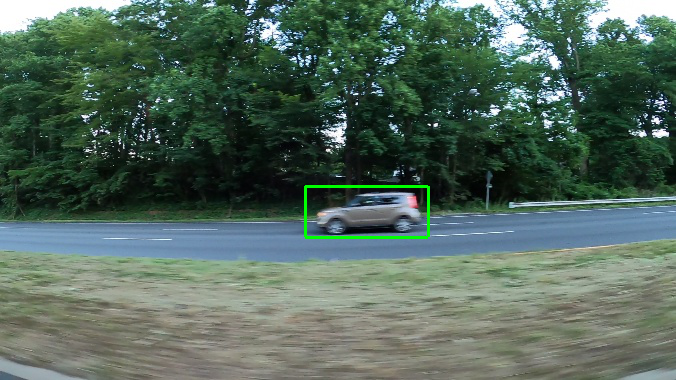

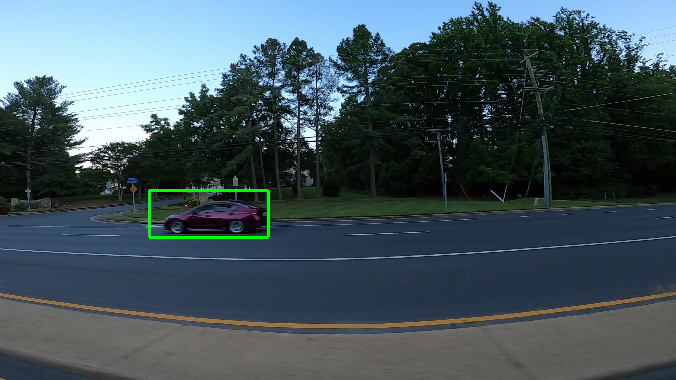

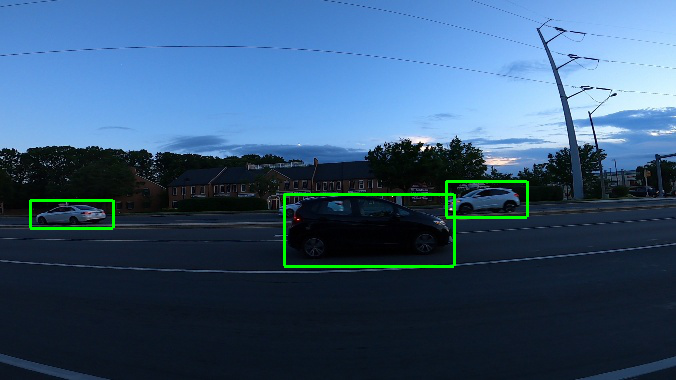

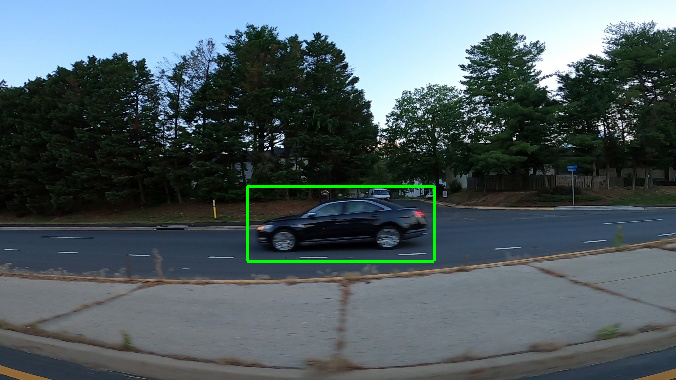

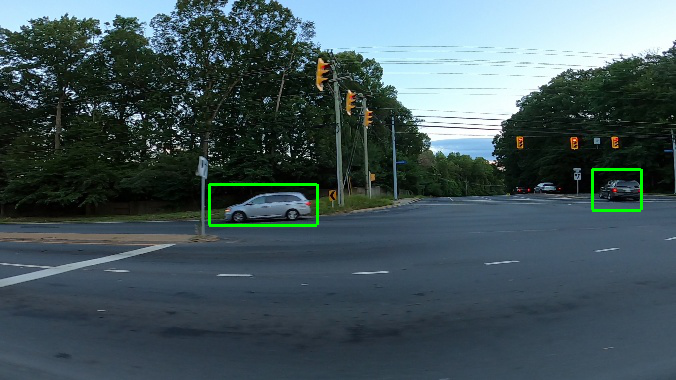

In [12]:
for i in range(5):
    idx = random.randrange(len(training_list))
    training_list[idx].draw_image_with_boxes()


In [13]:
train_X = np.concatenate([x.get_inputs() for x in training_list],axis=0)
train_y = np.concatenate([x.get_answer() for x in training_list],axis=0)

In [14]:
print(train_y.shape)
print(train_X.shape)

(355, 11, 21, 2)
(355, 380, 676, 3)


In [36]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2


def build_model():
    mobilenet = MobileNetV2(weights='imagenet',include_top=False)
    x = mobilenet.outputs[0]
    x = Conv2D(2,1)(x)
    #x = Dropout(0.5)(x)
    #x = Dropout(0.2)(x)
    #x = Dropout(0.8)(x)
    #x = Dropout(0.4)(x)
    #x = Dropout(0.6)(x)
    #x = Dense(1, activation='sigmoid')(x)
    x = Dense(2, activation='sigmoid')(x)
    #x = Dense(1, activation='relu')(x)
    #x = Dense(2, activation='relu')(x)    
    model = Model(mobilenet.inputs,x)
    model.compile('adam',loss = 'mse', metrics = 'accuracy')
    return model

In [37]:
model = build_model()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [38]:
history = model.fit(train_X,train_y,epochs=30, validation_split = 0.2)

Epoch 1/30
9/9 [==============================] - 119s 12s/step - loss: 0.7092 - accuracy: 0.9170 - val_loss: 1.0085 - val_accuracy: 0.2065
Epoch 2/30
9/9 [==============================] - 109s 12s/step - loss: 0.5350 - accuracy: 0.9733 - val_loss: 0.9987 - val_accuracy: 0.1305
Epoch 3/30
9/9 [==============================] - 110s 12s/step - loss: 0.5269 - accuracy: 0.9735 - val_loss: 0.9964 - val_accuracy: 0.1515
Epoch 4/30
9/9 [==============================] - 110s 12s/step - loss: 0.5235 - accuracy: 0.9732 - val_loss: 0.9949 - val_accuracy: 0.1777
Epoch 5/30
9/9 [==============================] - 124s 14s/step - loss: 0.5214 - accuracy: 0.9746 - val_loss: 0.9918 - val_accuracy: 0.2143
Epoch 6/30
9/9 [==============================] - 130s 14s/step - loss: 0.5204 - accuracy: 0.9755 - val_loss: 0.9884 - val_accuracy: 0.2396
Epoch 7/30
9/9 [==============================] - 122s 13s/step - loss: 0.5202 - accuracy: 0.9804 - val_loss: 0.9765 - val_accuracy: 0.2816
Epoch 8/30
9/9 [====

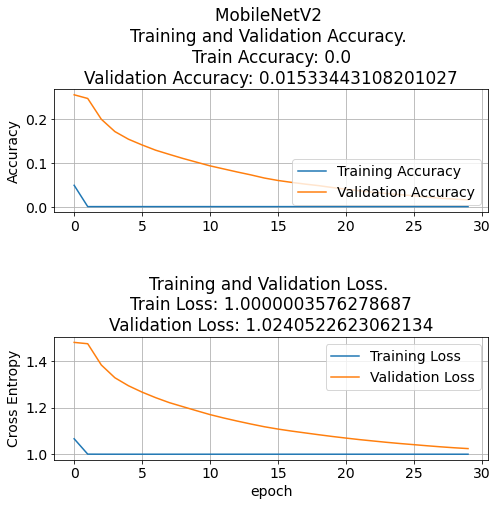

In [35]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
model.save('car_detection')

In [67]:
model_wrapper = KerasModelWrapper(model)

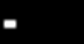

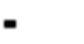

In [69]:
random_case = training_list[random.randrange(len(training_list))]
draw_outputs(random_case.get_answer_as_outputs())

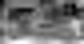

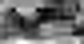

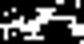

In [70]:
draw_outputs(model_wrapper.predict(random_case))

In [71]:
def load_test_images(path):
    cases = []
    for filename in os.listdir(path):
        file_path = path + '/' + filename
        case = TrainingCase(file_path)
        cases.append(case)
    
    return cases

In [72]:
def populate_boxes(model,case):
    prediction = model.predict(case)
    mask = prediction[2].copy()
    h,w = mask.shape
    boxes = []
    
    def walk_on_box(sx,sy):
        box = DetectionBox(sx,sy,sx,sy)
        q = Queue()
        q.put((sx,sy))
        while not q.empty():
            x,y = q.get()
            box.resize_to_point(x+1,y+1)
            mask[y,x] = False
            if y+1 < h and mask[y+1,x]:
                q.put((x,y+1))
            if y-1 >= 0 and mask[y-1,x]:
                q.put((x,y-1))
            if x+1 < w and mask[y,x+1]:
                q.put((x+1,y))
            if x-1 >= 0 and mask[y,x-1]:
                q.put((x-1,y))
        
        return box.scale(32)
    
    for y in range(h):
        for x in range(w):
            if mask[y,x]:
                boxes.append(walk_on_box(x,y))
    
    case.boxes = boxes

In [73]:
testing_list = load_test_images(testing_dataset_images_path)
for case in testing_list:
    populate_boxes(model_wrapper,case)

In [ ]:
#random examples of images and predictions

for i in range(5):
    idx = random.randrange(len(testing_list))
    while len(testing_list[idx].boxes) == 0:
        idx = random.randrange(len(testing_list))
    testing_list[idx].draw_image_with_boxes()